In [4]:
import pandas as pd
import json
from environs import Env
from graph_functions import query_to_df,start_graph_session,start_graph_session_crashdown, start_graph_session_crashdown_w_auth
from IPython.display import Image
import requests

env = Env()
#session = start_graph_session(env) 
session = start_graph_session_crashdown_w_auth(env) 

38687


# Looking at literature connections

In [13]:
# get all types of predicate
query="""
MATCH (gwas:Gwas)-[gs:GWAS_TO_LITERATURE_TRIPLE]->(triple:LiteratureTriple) -[sl:SEMMEDDB_TO_LIT]->(lit:Literature) 
return distinct triple.predicate limit 43
"""
#df = query_to_df(session, query)
#df

### Example query "GWAS - literature - GWAS"

In [34]:
# Childhood obesity GWAS-> breast cancer GWAS
# this is just a s test

query="""
MATCH (gwas:Gwas)-[gwas_to_lit1:GWAS_TO_LITERATURE_TRIPLE]->(s1:LiteratureTriple) 
-[:SEMMEDDB_OBJ]->(lit_term:LiteratureTerm)<-[:SEMMEDDB_SUB]- (s2:LiteratureTriple)<-[gwas_to_lit2:GWAS_TO_LITERATURE_TRIPLE]-(assoc_gwas:Gwas) 
WHERE gwas.id = "ieu-a-1096" AND assoc_gwas.id = "ieu-a-1126" 
AND gwas_to_lit1.pval < 1e-05 AND gwas_to_lit2.pval < 1e-05 
AND NOT lit_term.type IN ['nusq','dsyn'] 
RETURN distinct gwas.id, gwas.trait, gwas_to_lit1.pval,  s1.predicate, lit_term.name, s2.predicate, gwas_to_lit2.pval, assoc_gwas.id, assoc_gwas.trait 
order by gwas_to_lit2.pval
SKIP 0 LIMIT 1000
"""
df_obesity_lit = query_to_df(session, query)
#df_obesity_lit



MATCH (gwas:Gwas)-[gwas_to_lit1:GWAS_TO_LITERATURE_TRIPLE]->(s1:LiteratureTriple) 
-[:SEMMEDDB_OBJ]->(lit_term:LiteratureTerm)<-[:SEMMEDDB_SUB]- (s2:LiteratureTriple)<-[gwas_to_lit2:GWAS_TO_LITERATURE_TRIPLE]-(assoc_gwas:Gwas) 
WHERE gwas.id = "ieu-a-1096" AND assoc_gwas.id = "ieu-a-1126" 
AND gwas_to_lit1.pval < 1e-05 AND gwas_to_lit2.pval < 1e-05 
AND NOT lit_term.type IN ['nusq','dsyn'] 
RETURN distinct gwas.id, gwas.trait, gwas_to_lit1.pval,  s1.predicate, lit_term.name, s2.predicate, gwas_to_lit2.pval, assoc_gwas.id, assoc_gwas.trait 
order by gwas_to_lit2.pval
SKIP 0 LIMIT 1000



## Testing literature triples for genes of interest


In [2]:
genes_test_df = pd.read_csv("query_results/bc_gwas_expressed_in_breastTissue.tsv", sep = '\t') # from notebook 1
GENE_LIST = list(set(genes_test_df['gene.name']))
len(GENE_LIST) # genes expressed in breast tissues with effect in GWAS

98

In [10]:
# tophits in GWAS -> genes -> expressed in Breast tissue -> map to lit -> triple to other lit term
query = """
        MATCH (g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt:LiteratureTriple)-[]-(l2:LiteratureTerm)
        WHERE g.name in {gene_list}
        WITH  g,lt,l1,l2
        MATCH (lt)-[]-(lit:Literature) 
        RETURN l1.name as gene_as_litterm, lt.predicate as pred, l2.name as obj_as_litterm,
        l2.type as obj_as_littermType,  collect (lit.id) as  lit_ids;
    """.format(gene_list=GENE_LIST)
df= query_to_df(session, query)
df


        MATCH (g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt:LiteratureTriple)-[]-(l2:LiteratureTerm)
        WHERE g.name in ['TRIM46', 'OR2A1-AS1', 'NREP', 'CBX8', 'NRIP1', 'FAM175A', 'ULK3', 'LSP1', 'ZFPM2', 'USHBP1', 'STXBP4', 'FGFR2', 'PHLDA3', 'GATAD2A', 'RIN3', 'RNF115', 'PIK3R3', 'RCCD1', 'ABO', 'MCM8', 'ELL', 'CREB5', 'GRHL1', 'LMX1B', 'NEK10', 'CUX1', 'FTO', 'PIDD', 'PRC1', 'VGLL3', 'DNAJC1', 'SV2A', 'BABAM1', 'ANKLE1', 'KCNN4', 'AMFR', 'ADCY3', 'GIPR', 'TLR1', 'GAREM', 'FAM46A', 'MTMR11', 'FILIP1L', 'KRTCAP2', 'ATXN7', 'SETBP1', 'ATAD5', 'ADSSL1', 'RAD51B', 'TGFBR2', 'ESR1', 'HSPA4', 'LINC-PINT', 'SUB1', 'CHEK2', 'MDM4', 'EBF1', 'RP11-134G8.8', 'ZNF184', 'MAGI3', 'PDE4D', 'ARHGEF5', 'ASTN2', 'FOXP1', 'L3MBTL3', 'SF3B4', 'ADCY9', 'VPS33B', 'ARRDC3', 'PLA2G6', 'CDYL2', 'ITPR1', 'CDCA7L', 'MYEOV', 'ZMIZ1', 'CASP8', 'N4BP2L1', 'CCDC88C', 'RANBP9', 'CDKN2B', 'CMSS1', 'RPL23AP53', 'TET2', 'HSCB', 'ATG10', 'KANSL1', 'MLLT10', 'OTUD7B', 'LGR6', 'TTC28', 'SLC25A22', 'ZBTB38', 

,gene_as_litterm,pred,obj_as_litterm,obj_as_littermType,lit_ids
0,NRIP1,AFFECTS,Obesity,[dsyn],"[20205832, 20680503]"
1,NRIP1,INHIBITS,HOXA5,"[gngm, aapp]",[19862326]
2,NRIP1,COEXISTS_WITH,Tretinoin,"[phsu, orch, hops]",[19862326]
3,NRIP1,STIMULATES,"Receptors, Nuclear","[gngm, aapp]","[19862326, 19862326]"
4,NRIP1,INHIBITS,ERN1,"[gngm, aapp]",[28222026]
...,...,...,...,...,...
23594,TGFBR2,COEXISTS_WITH,connective tissue growth factor,"[gngm, aapp]",[23816882]
23595,TGFBR2,COEXISTS_WITH,NFIC,"[gngm, aapp]",[23933490]
23596,TGFBR2,INHIBITS,methamphetamine,"[phsu, orch, hops]",[17669262]
23597,TGFBR2,INTERACTS_WITH,CCAAT-Enhancer-Binding Protein-alpha,"[gngm, aapp]",[24284203]


In [11]:
len(set(df['gene_as_litterm']))
# 87 genes have a lit term mapping

87

In [12]:
df[df['gene_as_litterm'] == 'ESR1']

,gene_as_litterm,pred,obj_as_litterm,obj_as_littermType,lit_ids
18762,ESR1,NEG_INTERACTS_WITH,Genes,"[gngm, aapp]",[31514021]
18763,ESR1,STIMULATES,ESR2 gene,"[gngm, aapp]","[31514021, 31514021]"
18764,ESR1,INHIBITS,RNA Polymerase II,"[gngm, aapp]",[31504407]
18765,ESR1,INHIBITS,Cadherins,"[gngm, aapp]",[30604272]
18766,ESR1,PREDISPOSES,Osteoporosis,[dsyn],[31450614]
...,...,...,...,...,...
22280,ESR1,INTERACTS_WITH,reproductive hormone,[horm],"[30058584, 24045481]"
22281,ESR1,INTERACTS_WITH,Chlorotoxin,[aapp],[30806044]
22282,ESR1,COEXISTS_WITH,ROS1,"[gngm, aapp]",[25338520]
22283,ESR1,INHIBITS,MIR21,"[gngm, aapp]",[31354287]


## tophits in GWAS -> genes -> expressed in Breast tissue -> map to lit -> other term -> predicate to a disease

In [13]:
# where middle term contains 'breast'
query="""
MATCH (g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)-[]-(lt2:LiteratureTriple)-[]-(l3:LiteratureTerm)-[:MONDO_MAP_UMLS]-(d:Disease)
WHERE g.name in {} 
AND toLower(l2.name) contains 'breast'
WITH  g,l1,lt1, l2, lt2, l3, d
MATCH (lt1)-[]-(lit1:Literature) 
MATCH (lt2)-[]-(lit2:Literature) 
RETURN l1.name as term1, lt1.predicate as pred1,
        l2.name as term2 ,  lt2.predicate as pred2,
        l3.name as term3 , d.label as Disease,
        lit1.id, lit2.id
""".format(GENE_LIST)

df= query_to_df(session, query)
df


MATCH (g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)-[]-(lt2:LiteratureTriple)-[]-(l3:LiteratureTerm)-[:MONDO_MAP_UMLS]-(d:Disease)
WHERE g.name in ['TRIM46', 'OR2A1-AS1', 'NREP', 'CBX8', 'NRIP1', 'FAM175A', 'ULK3', 'LSP1', 'ZFPM2', 'USHBP1', 'STXBP4', 'FGFR2', 'PHLDA3', 'GATAD2A', 'RIN3', 'RNF115', 'PIK3R3', 'RCCD1', 'ABO', 'MCM8', 'ELL', 'CREB5', 'GRHL1', 'LMX1B', 'NEK10', 'CUX1', 'FTO', 'PIDD', 'PRC1', 'VGLL3', 'DNAJC1', 'SV2A', 'BABAM1', 'ANKLE1', 'KCNN4', 'AMFR', 'ADCY3', 'GIPR', 'TLR1', 'GAREM', 'FAM46A', 'MTMR11', 'FILIP1L', 'KRTCAP2', 'ATXN7', 'SETBP1', 'ATAD5', 'ADSSL1', 'RAD51B', 'TGFBR2', 'ESR1', 'HSPA4', 'LINC-PINT', 'SUB1', 'CHEK2', 'MDM4', 'EBF1', 'RP11-134G8.8', 'ZNF184', 'MAGI3', 'PDE4D', 'ARHGEF5', 'ASTN2', 'FOXP1', 'L3MBTL3', 'SF3B4', 'ADCY9', 'VPS33B', 'ARRDC3', 'PLA2G6', 'CDYL2', 'ITPR1', 'CDCA7L', 'MYEOV', 'ZMIZ1', 'CASP8', 'N4BP2L1', 'CCDC88C', 'RANBP9', 'CDKN2B', 'CMSS1', 'RPL23AP53', 'TET2', 'HSCB', 'ATG10', 'KANS

,term1,pred1,term2,pred2,term3,Disease,lit1.id,lit2.id
0,ESR1,ASSOCIATED_WITH,"Breast Fibrocystic Change, Proliferative Type",COEXISTS_WITH,Breast Diseases,breast disease,16327431,17417639
1,ESR1,ASSOCIATED_WITH,"Breast Fibrocystic Change, Proliferative Type",AFFECTS,Breast Diseases,breast disease,16327431,11289127
2,ARHGEF5,AFFECTS,"Breast Fibrocystic Change, Proliferative Type",COEXISTS_WITH,Breast Diseases,breast disease,14662653,17417639
3,ARHGEF5,AFFECTS,"Breast Fibrocystic Change, Proliferative Type",AFFECTS,Breast Diseases,breast disease,14662653,11289127


In [16]:
# test extracting sentences where those lit predicates come from:
def get_sentence_data(pmid):
    url = "https://melodi-presto.mrcieu.ac.uk/api/sentence/"
    params = { "pmid": pmid,}
    response = requests.post(url, data=json.dumps(params))
    res = response.json()
    df = pd.json_normalize(res)
    return df

sentence_data = get_sentence_data("17417639")
for ss in sentence_data["data"]:
    for s in ss:
        print(s["SUB_PRED_OBJ"])
        print("SENTENCE:", s["SENTENCE"])
        print("\n")

Breast Diseases:COEXISTS_WITH:Breast Fibrocystic Change, Proliferative Type
SENTENCE: Notably, we also found ESR1 amplification in benign and precancerous breast diseases, suggesting that ESR1 amplification may be a common mechanism in proliferative breast disease and a very early genetic alteration in a large subset of breast cancers.




In [18]:
# where the third term contains 'breast'
query="""
MATCH (g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)-[]-(lt2:LiteratureTriple)-[]-(l3:LiteratureTerm)-[:MONDO_MAP_UMLS]-(d:Disease)
WHERE g.name in {} 
AND toLower(l3.name) contains 'breast'
WITH  g,l1,lt1, l2, lt2, l3, d
MATCH (lt1)-[]-(lit1:Literature) 
MATCH (lt2)-[]-(lit2:Literature) 
RETURN l1.name as term1, lt1.predicate as pred1,
        l2.name as term2 ,  lt2.predicate as pred2,
        l3.name as term3 , d.label as Disease,
        lit1.id, lit2.id
""".format(GENE_LIST)

df= query_to_df(session, query)
df
#df=df[df["term2"]!= "Genes"]
#df.sort_values(by=['Disease'])
#df[df["pred1"] not in ["COEXISTS_WITH"]]


MATCH (g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)-[]-(lt2:LiteratureTriple)-[]-(l3:LiteratureTerm)-[:MONDO_MAP_UMLS]-(d:Disease)
WHERE g.name in ['TRIM46', 'OR2A1-AS1', 'NREP', 'CBX8', 'NRIP1', 'FAM175A', 'ULK3', 'LSP1', 'ZFPM2', 'USHBP1', 'STXBP4', 'FGFR2', 'PHLDA3', 'GATAD2A', 'RIN3', 'RNF115', 'PIK3R3', 'RCCD1', 'ABO', 'MCM8', 'ELL', 'CREB5', 'GRHL1', 'LMX1B', 'NEK10', 'CUX1', 'FTO', 'PIDD', 'PRC1', 'VGLL3', 'DNAJC1', 'SV2A', 'BABAM1', 'ANKLE1', 'KCNN4', 'AMFR', 'ADCY3', 'GIPR', 'TLR1', 'GAREM', 'FAM46A', 'MTMR11', 'FILIP1L', 'KRTCAP2', 'ATXN7', 'SETBP1', 'ATAD5', 'ADSSL1', 'RAD51B', 'TGFBR2', 'ESR1', 'HSPA4', 'LINC-PINT', 'SUB1', 'CHEK2', 'MDM4', 'EBF1', 'RP11-134G8.8', 'ZNF184', 'MAGI3', 'PDE4D', 'ARHGEF5', 'ASTN2', 'FOXP1', 'L3MBTL3', 'SF3B4', 'ADCY9', 'VPS33B', 'ARRDC3', 'PLA2G6', 'CDYL2', 'ITPR1', 'CDCA7L', 'MYEOV', 'ZMIZ1', 'CASP8', 'N4BP2L1', 'CCDC88C', 'RANBP9', 'CDKN2B', 'CMSS1', 'RPL23AP53', 'TET2', 'HSCB', 'ATG10', 'KANS

,term1,pred1,term2,pred2,term3,Disease,lit1.id,lit2.id
0,NRIP1,AFFECTS,Obesity,COEXISTS_WITH,Breast Diseases,breast disease,20205832,30376276
1,NRIP1,AFFECTS,Obesity,COEXISTS_WITH,Breast Diseases,breast disease,20680503,30376276
2,NRIP1,ASSOCIATED_WITH,Endometriosis,COEXISTS_WITH,Breast Diseases,breast disease,16131398,30932000
3,NRIP1,ASSOCIATED_WITH,Endometriosis,PREDISPOSES,Breast Diseases,breast disease,16131398,27604359
4,NRIP1,NEG_INHIBITS,Genes,ASSOCIATED_WITH,Breast Diseases,breast disease,20083575,25981900
...,...,...,...,...,...,...,...,...
35186,TGFBR2,COEXISTS_WITH,receptor,ASSOCIATED_WITH,Breast Diseases,breast disease,9688260,11819093
35187,TGFBR2,INHIBITS,Genes,ASSOCIATED_WITH,Breast Diseases,breast disease,27835699,25981900
35188,TGFBR2,INHIBITS,Genes,ASSOCIATED_WITH,Breast Diseases,breast disease,27835699,7937751
35189,TGFBR2,INHIBITS,Genes,AFFECTS,Fibrosclerosis of breast,breast fibrosis,27835699,29452196


## Mapping drugs to diseases via literature

In [2]:
# lets try some enterobiases drugs
enterobiasis_drugs_df = pd.read_csv("query_results/enterobiasis_drugs.tsv", sep = '\t')
enterobiasis_drugs = list(set(enterobiasis_drugs_df['drug.label']))

Actually try just one drug for now: ABEMACICLIB

In [20]:
# checking one DRUG
query = """
MATCH (drug:Drug)-[OPENTARGETS_DRUG_TO_TARGET]->(g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)-[]-(lt2:LiteratureTriple)-[]-(l3:LiteratureTerm)-[:MONDO_MAP_UMLS]-(d:Disease)
        where drug.label = 'ABEMACICLIB'
        WITH  drug, l1,lt1, l2, lt2, l3, d
        where tolower(d.label) contains 'breast'
        and not any(types in ['dsyn'] WHERE types IN l2.type)
        and not any(term in ['Genes', 'Proteins', 'Hormones', 'Receptors', 'Tumor Suppressor Genes'] WHERE term IN l2.name)
        RETURN drug.label as DRUG, 
                l1.name as term1_drugTarget, lt1.predicate as pred1,
                l2.name as term2 , l2.type as term2_type , lt2.predicate as pred2,
                l3.name as term3
    """

df= query_to_df(session, query)
df


MATCH (drug:Drug)-[OPENTARGETS_DRUG_TO_TARGET]->(g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)-[]-(lt2:LiteratureTriple)-[]-(l3:LiteratureTerm)-[:MONDO_MAP_UMLS]-(d:Disease)
        where drug.label = 'ABEMACICLIB'
        WITH  drug, l1,lt1, l2, lt2, l3, d
        where tolower(d.label) contains 'breast'
        and not any(types in ['dsyn'] WHERE types IN l2.type)
        and not any(term in ['Genes', 'Proteins', 'Hormones', 'Receptors', 'Tumor Suppressor Genes'] WHERE term IN l2.name)
        RETURN drug.label as DRUG, 
                l1.name as term1_drugTarget, lt1.predicate as pred1,
                l2.name as term2 , l2.type as term2_type , lt2.predicate as pred2,
                l3.name as term3
    


StopIteration: 

In [20]:
set(df['term3'])

{'Breast Diseases', 'Breast Fibrocystic Disease', 'Fibrosclerosis of breast'}

In [21]:
# make them all 'breast diseases'
df['term3'] = 'Breast Diseases'

In [22]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt


# create network data
d = []
d = df[["DRUG", "term1_drugTarget"]].values.tolist()
#d = d + df[["term3", "term3"]].values.tolist()
d = d + df[["term1_drugTarget", "term2"]].values.tolist()
d = d + df[["term2", "term3"]].values.tolist()


def add_newlines(text):
    text = text.replace(" ", "\n")
    return text

d_edit = []
for i in d:
    d_edit.append([add_newlines(x) for x in i])


# create the edge labels
labels = {}
for l in df[
    ["term1_drugTarget", "term2", "pred1"]].drop_duplicates().values.tolist():
    labels[(add_newlines(l[0]), add_newlines(l[1]))] = (add_newlines(l[2]))
    
for l in df[
    ["term2", "term3", "pred2"]].drop_duplicates().values.tolist():
    labels[(add_newlines(l[0]), add_newlines(l[1]))] = (
        add_newlines(l[2]))


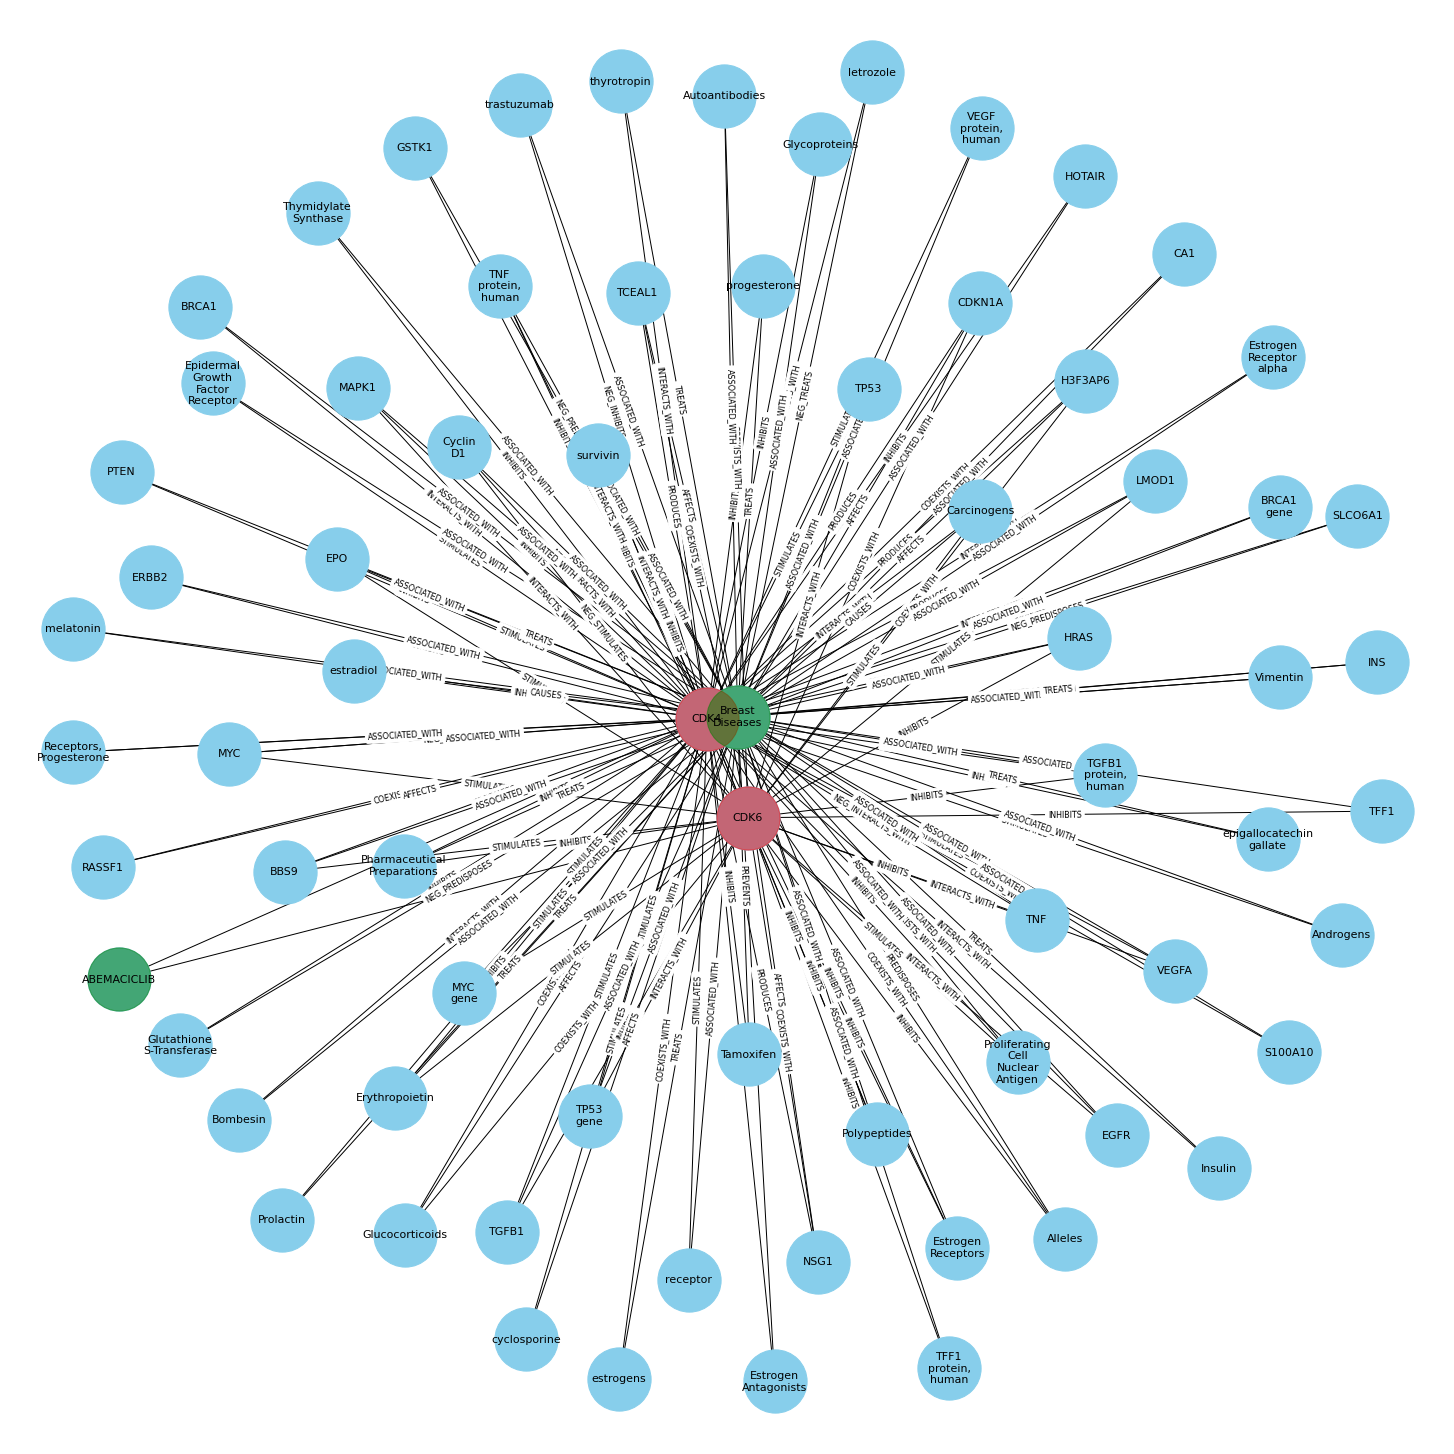

In [23]:
# create the network
plt.figure(figsize=(20, 20))

G = nx.Graph(d_edit)

pos = graphviz_layout(G)

node_size = 4000

nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=node_size,
    node_color="skyblue",
    font_size=11,
)

nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)


# colour the GWAS nodes
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=[ 'CDK4', 'CDK6'],#, 'Breast\nFibrocystic\nDisease', 'Fibrosclerosis\nof\nbreast'],
    node_color="r",
    node_size=node_size,
    alpha=0.5,
)
# colour the GWAS nodes
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=['ABEMACICLIB', 'Breast\nDiseases'],
    node_color="g",
    node_size=node_size,
    alpha=0.5,
)
plt.show()
#plt.savefig("figures/TEST.png")

#### map ABEMACICLIB to enterobiasis 

In [31]:
# checking one DRUG
query = """
MATCH (drug:Drug)-[OPENTARGETS_DRUG_TO_TARGET]->(g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)-[]-(lt2:LiteratureTriple)-[]-(l3:LiteratureTerm)-[:MONDO_MAP_UMLS]-(d:Disease)
        where drug.label = 'ABEMACICLIB'
        WITH  drug, l1,lt1, l2, lt2, l3, d
        where tolower(d.label) = 'enterobiasis'
        and not any(types in ['dsyn'] WHERE types IN l2.type)
        and not any(term in ['Genes', 'Proteins', 'Hormones', 'Receptors', 'Tumor Suppressor Genes'] WHERE term IN l2.name)
        RETURN drug.label as DRUG, 
                l1.name as term1_drugTarget, lt1.predicate as pred1,
                l2.name as term2 , l2.type as term2_type , lt2.predicate as pred2,
                l3.name as term3
    """
#.format(gene_list=GENE_LIST)
df= query_to_df(session, query)
df


MATCH (drug:Drug)-[OPENTARGETS_DRUG_TO_TARGET]->(g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)-[]-(lt2:LiteratureTriple)-[]-(l3:LiteratureTerm)-[:MONDO_MAP_UMLS]-(d:Disease)
        where drug.label = 'ABEMACICLIB'
        WITH  drug, l1,lt1, l2, lt2, l3, d
        where tolower(d.label) = 'enterobiasis'
        and not any(types in ['dsyn'] WHERE types IN l2.type)
        and not any(term in ['Genes', 'Proteins', 'Hormones', 'Receptors', 'Tumor Suppressor Genes'] WHERE term IN l2.name)
        RETURN drug.label as DRUG, 
                l1.name as term1_drugTarget, lt1.predicate as pred1,
                l2.name as term2 , l2.type as term2_type , lt2.predicate as pred2,
                l3.name as term3
    


,DRUG,term1_drugTarget,pred1,term2,term2_type,pred2,term3
0,ABEMACICLIB,CDK4,INHIBITS,Ivermectin,"[phsu, orch]",TREATS,Enterobiasis
1,ABEMACICLIB,CDK4,INHIBITS,Interferons,"[phsu, gngm, aapp]",ASSOCIATED_WITH,Enterobiasis
2,ABEMACICLIB,CDK6,INTERACTS_WITH,Pharmaceutical Preparations,[phsu],TREATS,Enterobiasis
3,ABEMACICLIB,CDK6,INHIBITS,Pharmaceutical Preparations,[phsu],TREATS,Enterobiasis
4,ABEMACICLIB,CDK6,INHIBITS,Pharmaceutical Preparations,[phsu],TREATS,Enterobiasis
5,ABEMACICLIB,CDK6,INTERACTS_WITH,Pharmaceutical Preparations,[phsu],TREATS,Enterobiasis
6,ABEMACICLIB,CDK4,INTERACTS_WITH,Pharmaceutical Preparations,[phsu],TREATS,Enterobiasis
7,ABEMACICLIB,CDK4,INHIBITS,Pharmaceutical Preparations,[phsu],TREATS,Enterobiasis
8,ABEMACICLIB,CDK4,INTERACTS_WITH,Pharmaceutical Preparations,[phsu],TREATS,Enterobiasis
9,ABEMACICLIB,CDK4,INHIBITS,Pharmaceutical Preparations,[phsu],TREATS,Enterobiasis


In [32]:
# checking TAMOXIFEN
query = """
MATCH (drug:Drug)-[OPENTARGETS_DRUG_TO_TARGET]->(g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)-[]-(lt2:LiteratureTriple)-[]-(l3:LiteratureTerm)-[:MONDO_MAP_UMLS]-(d:Disease)
        where drug.label = 'TAMOXIFEN'
        WITH  drug, l1,lt1, l2, lt2, l3, d
        where tolower(d.label) = 'enterobiasis'
        and not any(types in ['dsyn'] WHERE types IN l2.type)
        and not any(term in ['Genes', 'Proteins', 'Hormones', 'Receptors', 'Tumor Suppressor Genes'] WHERE term IN l2.name)
        RETURN drug.label as DRUG, 
                l1.name as term1_drugTarget, lt1.predicate as pred1,
                l2.name as term2 , l2.type as term2_type , lt2.predicate as pred2,
                l3.name as term3
    """
#.format(gene_list=GENE_LIST)
df= query_to_df(session, query)
df


MATCH (drug:Drug)-[OPENTARGETS_DRUG_TO_TARGET]->(g:Gene)<-[:TERM_TO_GENE]-(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)-[]-(lt2:LiteratureTriple)-[]-(l3:LiteratureTerm)-[:MONDO_MAP_UMLS]-(d:Disease)
        where drug.label = 'TAMOXIFEN'
        WITH  drug, l1,lt1, l2, lt2, l3, d
        where tolower(d.label) = 'enterobiasis'
        and not any(types in ['dsyn'] WHERE types IN l2.type)
        and not any(term in ['Genes', 'Proteins', 'Hormones', 'Receptors', 'Tumor Suppressor Genes'] WHERE term IN l2.name)
        RETURN drug.label as DRUG, 
                l1.name as term1_drugTarget, lt1.predicate as pred1,
                l2.name as term2 , l2.type as term2_type , lt2.predicate as pred2,
                l3.name as term3
    


,DRUG,term1_drugTarget,pred1,term2,term2_type,pred2,term3
0,TAMOXIFEN,ESR1,STIMULATES,Interferons,"[phsu, gngm, aapp]",ASSOCIATED_WITH,Enterobiasis
1,TAMOXIFEN,ESR1,COEXISTS_WITH,Interferons,"[phsu, gngm, aapp]",ASSOCIATED_WITH,Enterobiasis
2,TAMOXIFEN,ESR1,COEXISTS_WITH,Interferons,"[phsu, gngm, aapp]",ASSOCIATED_WITH,Enterobiasis
3,TAMOXIFEN,ESR1,INTERACTS_WITH,Interferons,"[phsu, gngm, aapp]",ASSOCIATED_WITH,Enterobiasis
4,TAMOXIFEN,ESR1,NEG_ISA,Pharmaceutical Preparations,[phsu],TREATS,Enterobiasis
5,TAMOXIFEN,ESR1,STIMULATES,Pharmaceutical Preparations,[phsu],TREATS,Enterobiasis
6,TAMOXIFEN,ESR1,INHIBITS,Pharmaceutical Preparations,[phsu],TREATS,Enterobiasis
7,TAMOXIFEN,ESR1,INTERACTS_WITH,Pharmaceutical Preparations,[phsu],TREATS,Enterobiasis
8,TAMOXIFEN,ESR1,COEXISTS_WITH,Pharmaceutical Preparations,[phsu],TREATS,Enterobiasis
9,TAMOXIFEN,ESR1,STIMULATES,Pharmaceutical Preparations,[phsu],TREATS,Enterobiasis


## Collect everything that may have downstream effect on BC

In [2]:
# GWAS to LIT is a useless connection in my case
query = """
MATCH (gwas:Gwas)-[GWAS_TO_LITERATURE]->(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)
where toLower(gwas.trait) contains "breast"
and not(toLower(gwas.trait) contains "baby") 
and not(toLower(gwas.trait) contains "mother")
and not(toLower(gwas.trait) contains "sibling")
and not(toLower(gwas.trait) contains "mammogram")
and not(toLower(gwas.trait) contains "cyst")
and not(toLower(gwas.trait) contains "protein")
//and not any(types in ['dsyn'] WHERE types IN l2.type)
//and not any(term in ['Genes', 'Proteins', 'Hormones', 'Receptors', 'Tumor Suppressor Genes'] WHERE term IN l2.name)
RETURN gwas.trait, 
        l1.name as term1_gwas, lt1.predicate as pred1,
        l2.name as term2 
    """
#.format(gene_list=GENE_LIST)
df= query_to_df(session, query)
df


MATCH (gwas:Gwas)-[GWAS_TO_LITERATURE]->(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)
where toLower(gwas.trait) contains "breast"
and not(toLower(gwas.trait) contains "baby") 
and not(toLower(gwas.trait) contains "mother")
and not(toLower(gwas.trait) contains "sibling")
and not(toLower(gwas.trait) contains "mammogram")
and not(toLower(gwas.trait) contains "cyst")
and not(toLower(gwas.trait) contains "protein")
//and not any(types in ['dsyn'] WHERE types IN l2.type)
//and not any(term in ['Genes', 'Proteins', 'Hormones', 'Receptors', 'Tumor Suppressor Genes'] WHERE term IN l2.name)
RETURN gwas.trait, 
        l1.name as term1_gwas, lt1.predicate as pred1,
        l2.name as term2 
    


""


In [24]:
query = """
MATCH (gwas:Gwas)-[GWAS_TO_LITERATURE]->(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)
where tolower(gwas.trait) contains "breast" 
and not(toLower(gwas.trait) contains "protein")
RETURN gwas.trait, gwas.id, l1.name as term1_gwas
"""

df= query_to_df(session, query)
df


MATCH (gwas:Gwas)-[GWAS_TO_LITERATURE]->(l1:LiteratureTerm)-[]-(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)
where tolower(gwas.trait) contains "breast" 
and not(toLower(gwas.trait) contains "protein")
RETURN gwas.trait, gwas.id, l1.name as term1_gwas



,gwas.trait,gwas.id,term1_gwas
0,Operation code: breast cyst/abscess removal,ukb-b-3370,Abscess


In [2]:
# GWAS_TO_LITERATURE_TRIPLE gets all lit triples realted to BC. returns both subj and obj lit terms
# this query is too long, and as later shown, can get most of tet terms just by quering the main GWAS and some other
query = """
MATCH (gwas:Gwas)-[GWAS_TO_LITERATURE_TRIPLE]->(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)
where toLower(gwas.trait) contains "breast"
RETURN gwas.trait, gwas.id,
        lt1.predicate as pred1,
        l2.name as term2
        """
df2= query_to_df(session, query)
df2


MATCH (gwas:Gwas)-[GWAS_TO_LITERATURE_TRIPLE]->(lt1:LiteratureTriple)-[]-(l2:LiteratureTerm)
where toLower(gwas.trait) contains "breast"
RETURN gwas.trait, gwas.id,
        lt1.predicate as pred1,
        l2.name as term2
        


,gwas.trait,gwas.id,pred1,term2
0,Malignant neoplasm of breast,ukb-d-C3_BREAST_3,PRODUCES,serine
1,Malignant neoplasm of breast,ukb-d-C3_BREAST_3,PRODUCES,Phosphoglycerate dehydrogenase
2,Malignant neoplasm of breast,ukb-d-C3_BREAST_3,PRODUCES,serine
3,Malignant neoplasm of breast,ukb-d-C3_BREAST_3,PRODUCES,Phosphoglycerate dehydrogenase
4,Malignant neoplasm of breast,ukb-d-C3_BREAST_3,PRODUCES,serine
...,...,...,...,...
1174623,Inflammatory disorders of breast,finn-a-N14_INFLAMMBREAST,INTERACTS_WITH,SPHINGOMYELINASE
1174624,Benign neoplasm of breast (ICD C excluded),finn-a-CD2_BENIGN_BREAST_EXALLC,INTERACTS_WITH,MIRN15A gene
1174625,Benign neoplasm of breast (ICD C excluded),finn-a-CD2_BENIGN_BREAST_EXALLC,INTERACTS_WITH,SPHINGOMYELINASE
1174626,Malignant neoplasm of breast (ICD C excluded),finn-a-C3_BREAST_3_EXALLC,INTERACTS_WITH,MIRN15A gene


### Review how gwas-to-gwas map was done in case studies

In [8]:
def get_gwas_pair_literature(gwas_id, assoc_gwas_id):
    endpoint = "/literature/gwas/pairwise"
    API_URL = "https://api.epigraphdb.org"
    url = f"{API_URL}{endpoint}"
    params = {
        "gwas_id": gwas_id,
        "assoc_gwas_id": assoc_gwas_id,
        "by_gwas_id": "true",
        "pval_threshold": 1e-1,
        "semmantic_types": ["nusq", "dsyn"],
        "blacklist": "True",
        "limit": 1000,
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    lit_df = pd.json_normalize(r.json()["results"])
    return lit_df



In [9]:
# run outside the function to see the query
endpoint = "/literature/gwas/pairwise"
API_URL = "https://api.epigraphdb.org"
url = f"{API_URL}{endpoint}"
params = {
    "gwas_id": "ieu-a-1088",
    "assoc_gwas_id": "ieu-a-6",
    "by_gwas_id": "true",
    "pval_threshold": 1e-1,
    "semmantic_types": ["nusq", "dsyn"],
    "blacklist": "True",
    "limit": 1000,
}
r = requests.get(url, params=params)
r.raise_for_status()
# see what the acual quesry is like
print(r.json()['metadata']['query'])

MATCH (gwas:Gwas)-[gs1:GWAS_TO_LITERATURE_TRIPLE]->(s1:LiteratureTriple) -[:SEMMEDDB_OBJ]->(st:LiteratureTerm)<-[:SEMMEDDB_SUB]- (s2:LiteratureTriple)<-[gs2:GWAS_TO_LITERATURE_TRIPLE]-(assoc_gwas:Gwas) WHERE gwas.id = "ieu-a-1088" AND assoc_gwas.id = "ieu-a-6" AND gs1.pval < 0.1 AND gs2.pval < 0.1 AND all(type in st.type where NOT type IN ['nusq','dsyn']) MATCH (s1)-[:SEMMEDDB_SUB]-(st1:LiteratureTerm) MATCH (s2)-[:SEMMEDDB_OBJ]-(st2:LiteratureTerm) RETURN gwas {.id, .trait}, gs1 {.pval, .localCount}, st1 {.name}, s1 {.id, .subject_id, .object_id, .predicate}, st {.name, .type}, s2 {.id, .subject_id, .object_id, .predicate}, st2 {.name}, gs2 {.pval, .localCount}, assoc_gwas {.id, .trait} SKIP 0 LIMIT 1000


In [10]:
GWAS_ID_X = "ieu-a-1088"
GWAS_ID_Y = "ieu-a-6"
lit_df = get_gwas_pair_literature(GWAS_ID_X, GWAS_ID_Y)
lit_df

,gwas.id,gwas.trait,gs1.pval,gs1.localCount,st1.name,s1.id,s1.subject_id,s1.object_id,s1.predicate,st.name,st.type,s2.id,s2.subject_id,s2.object_id,s2.predicate,gs2.pval,gs2.localCount,st2.name,assoc_gwas.id,assoc_gwas.trait
0,ieu-a-1088,Sleep duration,0.000095,2,Sulpiride,C0038803:INTERACTS_WITH:C0003596,C0038803,C0003596,INTERACTS_WITH,Apomorphine,"[orch, phsu]",C0003596:TREATS:C0242350,C0003596,C0242350,TREATS,0.045878,3,Erectile dysfunction,ieu-a-6,Coronary heart disease
1,ieu-a-1088,Sleep duration,0.000002,2,Glycine,C0017890:STIMULATES:C0033487,C0017890,C0033487,STIMULATES,propofol,"[orch, phsu]",C0033487:AUGMENTS:C0151744,C0033487,C0151744,AUGMENTS,0.002682,2,Myocardial Ischemia,ieu-a-6,Coronary heart disease
2,ieu-a-1088,Sleep duration,0.000002,2,Glycine,C0017890:STIMULATES:C0033487,C0017890,C0033487,STIMULATES,propofol,"[orch, phsu]",C0033487:TREATS:C0010054,C0033487,C0010054,TREATS,0.001627,2,Coronary Arteriosclerosis,ieu-a-6,Coronary heart disease
3,ieu-a-1088,Sleep duration,0.000019,2,gamma-aminobutyric acid,C0016904:STIMULATES:C0033487,C0016904,C0033487,STIMULATES,propofol,"[orch, phsu]",C0033487:AUGMENTS:C0151744,C0033487,C0151744,AUGMENTS,0.002682,2,Myocardial Ischemia,ieu-a-6,Coronary heart disease
4,ieu-a-1088,Sleep duration,0.000019,2,gamma-aminobutyric acid,C0016904:STIMULATES:C0033487,C0016904,C0033487,STIMULATES,propofol,"[orch, phsu]",C0033487:TREATS:C0010054,C0033487,C0010054,TREATS,0.001627,2,Coronary Arteriosclerosis,ieu-a-6,Coronary heart disease
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,ieu-a-1088,Sleep duration,0.000006,2,TUBB4B,10383:INTERACTS_WITH:C0001962,10383,C0001962,INTERACTS_WITH,ethanol,"[orch, phsu]",C0001962:INTERACTS_WITH:C1318700,C0001962,C1318700,INTERACTS_WITH,0.000089,3,Phosphodiesterase 5 inhibitor,ieu-a-6,Coronary heart disease
996,ieu-a-1088,Sleep duration,0.000006,2,TUBB4B,10383:INTERACTS_WITH:C0001962,10383,C0001962,INTERACTS_WITH,ethanol,"[orch, phsu]",C0001962:AFFECTS:C0020538,C0001962,C0020538,AFFECTS,0.002637,3,Hypertensive disease,ieu-a-6,Coronary heart disease
997,ieu-a-1088,Sleep duration,0.000006,2,TUBB4B,10383:INTERACTS_WITH:C0001962,10383,C0001962,INTERACTS_WITH,ethanol,"[orch, phsu]",C0001962:PREVENTS:C0004153,C0001962,C0004153,PREVENTS,0.000154,4,Atherosclerosis,ieu-a-6,Coronary heart disease
998,ieu-a-1088,Sleep duration,0.000006,2,TUBB4B,10383:INTERACTS_WITH:C0001962,10383,C0001962,INTERACTS_WITH,ethanol,"[orch, phsu]",C0001962:CAUSES:C0002963,C0001962,C0002963,CAUSES,0.000005,4,"Angina Pectoris, Variant",ieu-a-6,Coronary heart disease


In [8]:
# testing getting all objects for 1126 gwas
query = """
MATCH (gwas:Gwas)-[gs1:GWAS_TO_LITERATURE_TRIPLE]->(s1:LiteratureTriple) -[:SEMMEDDB_OBJ]->(st:LiteratureTerm)
WHERE gwas.id = "ieu-a-1126" 
AND gs1.pval < 0.1
MATCH (s1)-[:SEMMEDDB_SUB]-(st1:LiteratureTerm) 
RETURN gwas {.id, .trait}, 
gs1 {.pval, .localCount}, st1 {.name}, s1 {.id, .subject_id, .object_id, .predicate}, st {.name, .type}
"""
test1= query_to_df(session, query,  True)
test1


MATCH (gwas:Gwas)-[gs1:GWAS_TO_LITERATURE_TRIPLE]->(s1:LiteratureTriple) -[:SEMMEDDB_OBJ]->(st:LiteratureTerm)
WHERE gwas.id = "ieu-a-1126" 
AND gs1.pval < 0.1
MATCH (s1)-[:SEMMEDDB_SUB]-(st1:LiteratureTerm) 
MATCH (s1)-[]-(lit:Literature) 
RETURN gwas {.id, .trait}, 
gs1 {.pval, .localCount}, st1 {.name}, s1 {.id, .subject_id, .object_id, .predicate}, st {.name, .type}, lit.id, lit.year, lit.dp



,lit.id,lit.year,lit.dp,gwas.trait,gwas.id,gs1.localCount,gs1.pval,st1.name,s1.subject_id,s1.predicate,s1.id,s1.object_id,st.name,st.type
0,21798065,2011,2011 Jul 29,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2,0.002769,urinastatin,C0077906,INHIBITS,C0077906:INHIBITS:5328,5328,PLAU,"[rcpt, gngm, bacs, phsu, enzy, aapp]"
1,9454892,1998,1998 Jan,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2,0.002769,urinastatin,C0077906,INHIBITS,C0077906:INHIBITS:5328,5328,PLAU,"[rcpt, gngm, bacs, phsu, enzy, aapp]"
2,21798065,2011,2011 Jul 29,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2,0.002769,urinastatin,C0077906,INHIBITS,C0077906:INHIBITS:C0042071,C0042071,urokinase,"[gngm, phsu, enzy, aapp]"
3,19660858,2010,2010 Feb 28,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2,0.002769,urinastatin,C0077906,INHIBITS,C0077906:INHIBITS:C0042071,C0042071,urokinase,"[gngm, phsu, enzy, aapp]"
4,21544423,1996,1996 Apr,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2,0.002769,urinastatin,C0077906,INHIBITS,C0077906:INHIBITS:C0042071,C0042071,urokinase,"[gngm, phsu, enzy, aapp]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470441,11919179,2002,2002 Jun 07,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2,0.004107,Hemoglobin,C0019046,INTERACTS_WITH,C0019046:INTERACTS_WITH:C0069139,C0069139,nucleolin,"[gngm, bacs, aapp]"
470442,21798065,2011,2011 Jul 29,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2,0.001680,urinastatin,C0077906,INHIBITS,C0077906:INHIBITS:5329,5329,PLAUR,"[rcpt, gngm, aapp]"
470443,21798065,2011,2011 Jul 29,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2,0.001680,urinastatin,C0077906,INHIBITS,C0077906:INHIBITS:C0071216,C0071216,Urokinase Plasminogen Activator Receptor,"[rcpt, gngm, aapp]"
470444,21798065,2011,2011 Jul 29,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2,0.002769,urinastatin,C0077906,INHIBITS,C0077906:INHIBITS:118471,118471,PRAP1,"[rcpt, gngm, phsu, enzy, aapp]"


In [9]:
test1.to_csv("../query_results/lit_bc1126_only.tsv", sep="\t", index=False)

In [ ]:
### this works and return correct number of localcounts!
MATCH (gwas:Gwas)-[gs1:GWAS_TO_LITERATURE_TRIPLE]->(s1:LiteratureTriple) -[:SEMMEDDB_OBJ]->(st:LiteratureTerm)
WHERE gwas.id = "ieu-a-1126" 
AND gs1.pval < 0.1
WITH gwas, gs1, s1, st
MATCH (s1)-[:SEMMEDDB_SUB]-(st1:LiteratureTerm) 
where st1.name = "NOS2A protein, human"
and st.name = 'TP53'
MATCH (gwas)-[:GWAS_TO_LITERATURE]-(lit:Literature)-[]-(s1)
RETURN gwas {.id, .trait}, 
gs1 {.pval, .localCount}, st1 {.name}, s1 {.id, .subject_id, .object_id, .predicate}, st {.name, .type}, lit.id, lit.year, lit.dp

In [11]:
##YES get all terms related to 'breast' gwas:
query = """
MATCH (gwas:Gwas)-[gs1:GWAS_TO_LITERATURE_TRIPLE]->(s1:LiteratureTriple) -[:SEMMEDDB_OBJ]->(st:LiteratureTerm)
where gwas.id in ['ieu-a-1126','finn-a-C3_BREAST', 'finn-a-CD2_BENIGN_BREAST', 'ukb-a-519', 'ukb-d-C3_BREAST_3', 'ukb-d-D05']
AND gs1.pval < 0.1
WITH gwas, gs1, s1, st
MATCH (s1)-[:SEMMEDDB_SUB]-(st1:LiteratureTerm) 
MATCH (gwas)-[:GWAS_TO_LITERATURE]-(lit:Literature)-[]-(s1)
RETURN gwas {.id, .trait}, gs1 {.pval, .localCount}, st1 {.name, .type}, s1 {.id, .subject_id, .object_id, .predicate}, st {.name, .type}, lit.id, lit.year, lit.dp
"""
test3 = query_to_df(session, query)
test3


MATCH (gwas:Gwas)-[gs1:GWAS_TO_LITERATURE_TRIPLE]->(s1:LiteratureTriple) -[:SEMMEDDB_OBJ]->(st:LiteratureTerm)
where gwas.id in ['ieu-a-1126','finn-a-C3_BREAST', 'finn-a-CD2_BENIGN_BREAST', 'ukb-a-519', 'ukb-d-C3_BREAST_3', 'ukb-d-D05']
AND gs1.pval < 0.1
WITH gwas, gs1, s1, st
MATCH (s1)-[:SEMMEDDB_SUB]-(st1:LiteratureTerm) 
MATCH (gwas)-[:GWAS_TO_LITERATURE]-(lit:Literature)-[]-(s1)
RETURN gwas {.id, .trait}, gs1 {.pval, .localCount}, st1 {.name, .type}, s1 {.id, .subject_id, .object_id, .predicate}, st {.name, .type}, lit.id, lit.year, lit.dp



,lit.id,lit.year,lit.dp,gwas.trait,gwas.id,gs1.localCount,gs1.pval,st1.name,st1.type,s1.subject_id,s1.predicate,s1.id,s1.object_id,st.name,st.type
0,21617236,2011,2011 May,Diagnoses - main ICD10: D05 Carcinoma in situ ...,ukb-d-D05,2,4.416903e-07,Vascular Endothelial Growth Factor Receptor-3,"[gngm, enzy, aapp]",C0169539,COEXISTS_WITH,C0169539:COEXISTS_WITH:2064,2064,ERBB2,"[gngm, phsu, imft, enzy, aapp]"
1,21617236,2011,2011 May,Diagnoses - main ICD10: D05 Carcinoma in situ ...,ukb-d-D05,2,4.416903e-07,Vascular Endothelial Growth Factor Receptor-3,"[gngm, enzy, aapp]",C0169539,COEXISTS_WITH,C0169539:COEXISTS_WITH:C0069515,C0069515,erbB-2 Receptor,"[gngm, enzy, aapp]"
2,25204840,2014,2014 Jun 25,Diagnoses - main ICD10: D05 Carcinoma in situ ...,ukb-d-D05,2,1.103827e-06,recombinant FVIIa,"[gngm, phsu, aapp]",C0534191,ASSOCIATED_WITH,C0534191:ASSOCIATED_WITH:C0015503,C0015503,Factor VII Deficiency,[dsyn]
3,24980142,2014,2014 Jun 24,Diagnoses - main ICD10: D05 Carcinoma in situ ...,ukb-d-D05,2,1.103827e-06,recombinant FVIIa,"[gngm, phsu, aapp]",C0534191,ASSOCIATED_WITH,C0534191:ASSOCIATED_WITH:C0015503,C0015503,Factor VII Deficiency,[dsyn]
4,17563907,2007,2007 Oct,Diagnoses - main ICD10: D05 Carcinoma in situ ...,ukb-d-D05,2,1.545078e-06,trastuzumab,"[gngm, phsu, imft, aapp]",C0728747,TREATS,C0728747:TREATS:C0277556,C0277556,Recurrent disease,[dsyn]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348222,21812966,2011,2011 Aug 03,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2,4.107003e-03,Hemoglobin,"[gngm, bacs, aapp]",C0019046,INTERACTS_WITH,C0019046:INTERACTS_WITH:C0069139,C0069139,nucleolin,"[gngm, bacs, aapp]"
348223,14717698,2004,2004 Jan,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2,4.107003e-03,Hemoglobin,"[gngm, bacs, aapp]",C0019046,INTERACTS_WITH,C0019046:INTERACTS_WITH:C0069139,C0069139,nucleolin,"[gngm, bacs, aapp]"
348224,21798065,2011,2011 Jul 29,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2,1.680375e-03,urinastatin,"[carb, gngm, phsu, aapp]",C0077906,INHIBITS,C0077906:INHIBITS:5329,5329,PLAUR,"[rcpt, gngm, aapp]"
348225,21798065,2011,2011 Jul 29,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2,1.680375e-03,urinastatin,"[carb, gngm, phsu, aapp]",C0077906,INHIBITS,C0077906:INHIBITS:C0071216,C0071216,Urokinase Plasminogen Activator Receptor,"[rcpt, gngm, aapp]"


In [6]:
test3

,lit.id,lit.year,lit.dp,gwas.trait,gwas.id,gs1.localCount,gs1.pval,st1.name,st1.type,s1.subject_id,s1.predicate,s1.id,s1.object_id,st.name,st.type
0,21798065,2011,2011 Jul 29,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2,0.002769,urinastatin,"[carb, gngm, phsu, aapp]",C0077906,INHIBITS,C0077906:INHIBITS:5328,5328,PLAU,"[rcpt, gngm, bacs, phsu, enzy, aapp]"
1,9454892,1998,1998 Jan,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2,0.002769,urinastatin,"[carb, gngm, phsu, aapp]",C0077906,INHIBITS,C0077906:INHIBITS:5328,5328,PLAU,"[rcpt, gngm, bacs, phsu, enzy, aapp]"
2,21798065,2011,2011 Jul 29,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2,0.002769,urinastatin,"[carb, gngm, phsu, aapp]",C0077906,INHIBITS,C0077906:INHIBITS:C0042071,C0042071,urokinase,"[gngm, phsu, enzy, aapp]"
3,19660858,2010,2010 Feb 28,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2,0.002769,urinastatin,"[carb, gngm, phsu, aapp]",C0077906,INHIBITS,C0077906:INHIBITS:C0042071,C0042071,urokinase,"[gngm, phsu, enzy, aapp]"
4,21544423,1996,1996 Apr,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2,0.002769,urinastatin,"[carb, gngm, phsu, aapp]",C0077906,INHIBITS,C0077906:INHIBITS:C0042071,C0042071,urokinase,"[gngm, phsu, enzy, aapp]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470441,11919179,2002,2002 Jun 07,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2,0.004107,Hemoglobin,"[gngm, bacs, aapp]",C0019046,INTERACTS_WITH,C0019046:INTERACTS_WITH:C0069139,C0069139,nucleolin,"[gngm, bacs, aapp]"
470442,21798065,2011,2011 Jul 29,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2,0.001680,urinastatin,"[carb, gngm, phsu, aapp]",C0077906,INHIBITS,C0077906:INHIBITS:5329,5329,PLAUR,"[rcpt, gngm, aapp]"
470443,21798065,2011,2011 Jul 29,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2,0.001680,urinastatin,"[carb, gngm, phsu, aapp]",C0077906,INHIBITS,C0077906:INHIBITS:C0071216,C0071216,Urokinase Plasminogen Activator Receptor,"[rcpt, gngm, aapp]"
470444,21798065,2011,2011 Jul 29,Breast cancer (Combined Oncoarray; iCOGS; GWAS...,ieu-a-1126,2,0.002769,urinastatin,"[carb, gngm, phsu, aapp]",C0077906,INHIBITS,C0077906:INHIBITS:118471,118471,PRAP1,"[rcpt, gngm, phsu, enzy, aapp]"


In [13]:
test3.to_csv("../query_results/lit_bc_to_other_litterms_upd.tsv", sep="\t", index=False)

### Let try get triples for any other GWAS

In [5]:
## ieu-a-1050 - ferritin
query = """
MATCH (gwas:Gwas)-[gs1:GWAS_TO_LITERATURE_TRIPLE]->(s1:LiteratureTriple) -[:SEMMEDDB_OBJ]->(st:LiteratureTerm)
WHERE gwas.id = 'met-a-362'
AND gs1.pval < 0.1
WITH gwas, gs1, s1, st
MATCH (s1)-[:SEMMEDDB_SUB]-(st1:LiteratureTerm) 
MATCH (gwas)-[:GWAS_TO_LITERATURE]-(lit:Literature)-[]-(s1)
RETURN gwas {.id, .trait}, gs1 {.pval, .localCount}, st1 {.name, .type}, s1 {.id, .subject_id, .object_id, .predicate}, st {.name, .type}, lit.id, lit.year, lit.dp
"""
other_gwas = query_to_df(session, query)
other_gwas


MATCH (gwas:Gwas)-[gs1:GWAS_TO_LITERATURE_TRIPLE]->(s1:LiteratureTriple) -[:SEMMEDDB_OBJ]->(st:LiteratureTerm)
WHERE gwas.id = 'met-a-362'
AND gs1.pval < 0.1
WITH gwas, gs1, s1, st
MATCH (s1)-[:SEMMEDDB_SUB]-(st1:LiteratureTerm) 
MATCH (gwas)-[:GWAS_TO_LITERATURE]-(lit:Literature)-[]-(s1)
RETURN gwas {.id, .trait}, gs1 {.pval, .localCount}, st1 {.name, .type}, s1 {.id, .subject_id, .object_id, .predicate}, st {.name, .type}, lit.id, lit.year, lit.dp



,lit.id,lit.year,lit.dp,gwas.trait,gwas.id,gs1.localCount,gs1.pval,st1.name,st1.type,s1.subject_id,s1.predicate,s1.id,s1.object_id,st.name,st.type
0,32599111,2020,2020 Jun 26,Betaine,met-a-362,2,2.871462e-06,trimethyloxamine,"[orch, phsu]",C0077194,TREATS,C0077194:TREATS:C0241868,C0241868,acute aortic dissection,[dsyn]
1,32429524,2020,2020 May 17,Betaine,met-a-362,2,2.871462e-06,chitosan,"[carb, orch, phsu]",C0162969,INTERACTS_WITH,C0162969:INTERACTS_WITH:C0003402,C0003402,Antioxidants,[phsu]
2,32036662,2020,2020 Feb 10,Betaine,met-a-362,2,2.871462e-06,Micelles,"[orch, sbst]",C0025938,INTERACTS_WITH,C0025938:INTERACTS_WITH:C0010467,C0010467,curcumin,"[orch, phsu, irda]"
3,23331204,2013,2013,Betaine,met-a-362,2,7.275106e-05,homocysteine,"[gngm, bacs, aapp]",C0019878,INHIBITS,C0019878:INHIBITS:C0010654,C0010654,cysteine,"[gngm, bacs, aapp]"
4,27288195,2016,2016 Oct,Betaine,met-a-362,2,7.275106e-05,homocysteine,"[gngm, bacs, aapp]",C0019878,INHIBITS,C0019878:INHIBITS:C0010654,C0010654,cysteine,"[gngm, bacs, aapp]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,2629632,1989,1989 Jul,Betaine,met-a-362,25,1.196788e-65,betaine,"[orch, phsu]",C0005304,TREATS,C0005304:TREATS:C0019880,C0019880,Homocystinuria,[dsyn]
1454,9025725,1997,1997 Jan 31,Betaine,met-a-362,25,1.196788e-65,betaine,"[orch, phsu]",C0005304,TREATS,C0005304:TREATS:C0019880,C0019880,Homocystinuria,[dsyn]
1455,9501279,1998,1998 Feb,Betaine,met-a-362,25,1.196788e-65,betaine,"[orch, phsu]",C0005304,TREATS,C0005304:TREATS:C0019880,C0019880,Homocystinuria,[dsyn]
1456,23862077,2013,2013,Betaine,met-a-362,25,1.196788e-65,betaine,"[orch, phsu]",C0005304,TREATS,C0005304:TREATS:C0019880,C0019880,Homocystinuria,[dsyn]


In [7]:
other_gwas.to_csv("../query_results/lit_betaine_triples.tsv", sep="\t", index=False)

In [ ]:
## Testing EFO_TO_LIT

In [ ]:
query = """
MATCH (gwas:Gwas)-[gs1:GWAS_TO_LITERATURE_TRIPLE]->(s1:LiteratureTriple) -[:SEMMEDDB_OBJ]->(st:LiteratureTerm)
WHERE gwas.id = 'met-a-362'
AND gs1.pval < 0.1
MATCH (s1)-[:SEMMEDDB_SUB]-(st1:LiteratureTerm) 
MATCH (s1)-[]-(lit:Literature) 
RETURN lit.id, lit.year,  gwas {.id, .trait}, 
gs1 {.pval, .localCount}, st1 {.name, .type}, s1 {.id, .subject_id, .object_id, .predicate}, st {.name, .type}
"""
other_gwas = query_to_df(session, query)
other_gwas